# General Type{T} Parareal algorithm

In [1]:
# Backward Euler Method
using LinearAlgebra
function backeuler(::Type{T}, a, b, u0, N) where T<:AbstractFloat
    u::Vector{T}=zeros(N+1)
    dt=(b-a)/N
    t=Vector{T}(range(a, b, N+1))
    #Solving for du/dt= -u+sin(10t)
    u[1]=u0
    for i in 1:N
        u[i+1]=(u[i].+ dt*sin(10*t[i+1]))/(1 + dt)
    end
    return t, u
end

backeuler (generic function with 1 method)

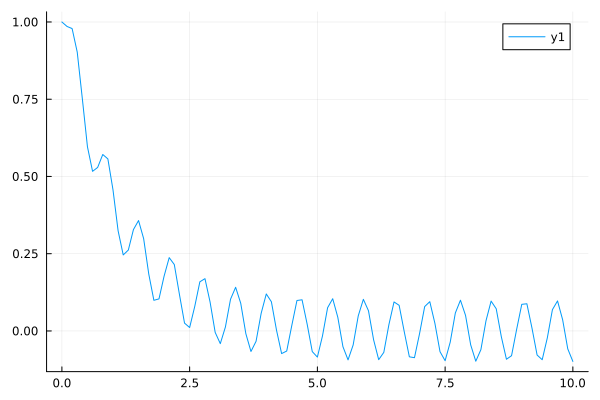

In [2]:
using Plots
t, u=backeuler(Float64, 0, 10, 1, 100)
plot(t, u)

In [3]:
# Parareal method
function parareal(::Type{T}, a, b, u0, N, F, G, K) where T<:AbstractFloat
    # a= start time value (t0)
    # b= End time value (tend)
    # N= Number of Subinterval
    # u0=initial Solution
    # F= Fine Solver
    # G= Coarse Solver
    # K= Parareal iteration
    
    tval=Vector(range(a, b, N+1))
    # Storing Fine Solution on each time step for comparison
    Ufine::Vector{T}=zeros(N+1)
    Ufine[1]=u0
    for i in 1:N
        Ufine[i+1]=F(T, tval[i], tval[i+1], Ufine[i])
    end
    # Initializing Uk
    Uk::Vector{Vector{T}}=[zeros(N+1) for k in 1:K+1]
    #Storing the initial solution
    for k in 1:K+1
        Uk[k][1]=u0
    end
    # Parareal Initialization
    for j in 1:N
        #Uk[1][j+1]=G(tval[j], tval[j+1], Uk[1][j])
        Uk[1][j+1]= 10.0 # May take random initial guess
    end
    # Parareal loop
    for k in 1:K
        for i in 1:N
            Fk0=F(T, tval[i], tval[i+1], Uk[k][i])
            Gk0=G(T, tval[i], tval[i+1], Uk[k][i])
            Gk1=G(T, tval[i], tval[i+1], Uk[k+1][i])
            
            Uk[k+1][i+1]=Fk0 + Gk1 - Gk0
        end
    end
    
    return Uk, Ufine, tval
  
end

parareal (generic function with 1 method)

In [4]:
function Fs(::Type{T},a, b, u0) where T<:AbstractFloat
    t, u=backeuler(T, a, b, u0, nF)
    return u[end]
end

Fs (generic function with 1 method)

In [5]:
function Gs(::Type{T},a, b, u0) where T<:AbstractFloat
    t, u=backeuler(T, a, b, u0, nG)
    return u[end]
end

Gs (generic function with 1 method)

# Convergence analysis of Double Precision Parareal

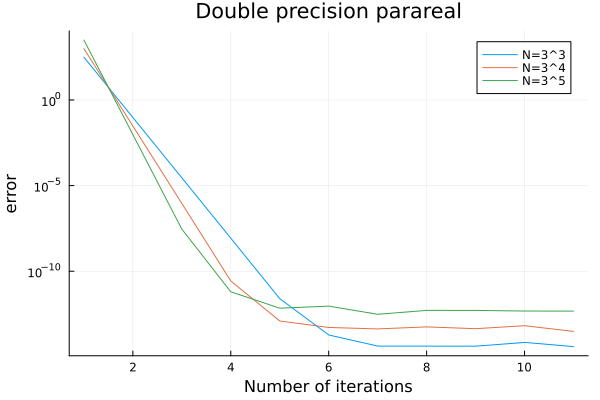

In [6]:
# Convergence Analysis in uniform double precision
a=0
b=10
u0=1

nF=1000 # Fine grid
nG=15 # Coarse grid
K=10 # Number of iteration
p = 3
N = zeros(p)
for i in 1:p
    N[i] = Int(floor(10^(i+2)))
end

err_double=zeros(p, K+1)
# Parareal Solution
for i in 1:p
    Uk, Ufine, tval=parareal(Float64, a, b, u0, convert(Int, N[i]), Fs, Gs, K)

    # stroing errors
    
    for k in 1:K+1
        err_double[i, k]=norm(Uk[k]-Ufine)
    end

end

using Plots
plot(err_double[1,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^3", title="Double precision parareal")
for j in 2:p
    plot!(err_double[j,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^$(j+2)")
end
display(plot!(legend=:topright))

# Convergence analysis of Single Precision Parareal

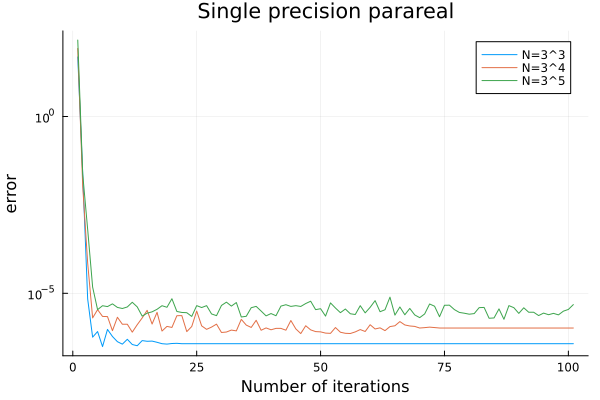

In [7]:
# Convergence Analysis in uniform single precision
a=0
b=1
u0=1
nF=1000 # Fine grid
nG=15 # Coarse grid
K=100 # Number of iteration
p = 3
N = zeros(p)
for i in 1:p
    N[i] = Int(floor(3^(i+2)))
end

err_single=zeros(p, K+1)
# Parareal Solution
for i in 1:p
    Uk, Ufine, tval=parareal(Float32, a, b, u0, convert(Int, N[i]), Fs, Gs, K)

    # stroing errors
    
    for k in 1:K+1
        err_single[i, k]=norm(Uk[k]-Ufine)
    end

end

using Plots
plot(err_single[1,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^3", title="Single precision parareal")
for j in 2:p
    plot!(err_single[j,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^$(j+2)")
end
display(plot!(legend=:topright))

# Convergence Analysis of Parareal Algorithm in Half Precision

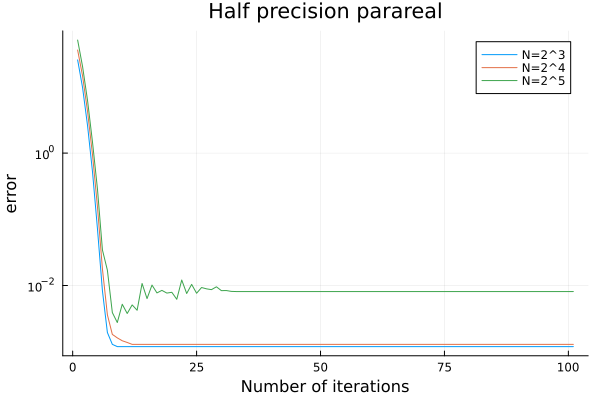

In [8]:
# Convergence Analysis in uniform half precision.
a=0
b=1
u0=1
nF=1000 # Fine grid
nG=15 # Coarse grid
K=100 # Number of iteration
p = 3
N = zeros(p)
for i in 1:p
    N[i] = Int(floor(2^(i+2)))
end

err_half=zeros(p, K+1)
# Parareal Solution
for i in 1:p
    Uk, Ufine, tval=parareal(Float16, a, b, u0, convert(Int, N[i]), Fs, Gs, K)

    # stroing errors
    
    for k in 1:K+1
        err_half[i, k]=norm(Uk[k]-Ufine)
    end

end

using Plots
plot(err_half[1,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=2^3", title="Half precision parareal")
for j in 2:p
    plot!(err_half[j,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=2^$(j+2)")
end
display(plot!(legend=:topright))

# Modified Parareal Algorithm in Mixed (Single and Double) Precision

In [9]:
# Modified Parareal method in mixed (Single and Double) precision
function mmsdparareal(::Type{T}, a, b, u0, N, F, G, K) where T<:AbstractFloat
    # a= start time value (t0)
    # b= End time value (tend)
    # N= Number of Subinterval
    # u0=initial Solution
    # F= Fine Solver
    # G= Coarse Solver
    # K= Parareal iteration
    
    tval=Vector(range(a, b, N+1))
    # Storing Fine Solution on each time step for comparison
    Ufine=Vector{Float64}(undef, N+1)
    Ufine[1]=u0
    for i in 1:N
        Ufine[i+1]=F(Float64, tval[i], tval[i+1], Ufine[i])
    end
    # Initializing Uk
    Uk=[Vector{Float64}(undef, N+1) for k in 1:K+1]
    #Storing the initial solution
    for k in 1:K+1
        Uk[k][1]=u0
    end
    # Parareal Initialization
    for j in 1:N
        #Uk[1][j+1]=G(tval[j], tval[j+1], Uk[1][j])
        Uk[1][j+1]=Float32(10) # may take random initial guess
    end
    # Parareal loop
    δUk=[Vector{Float32}(undef, N+1) for k in 1:K+1]
    for k in 1:K
        for i in 1:N
            δUk[k][i]=Uk[k+1][i]-Uk[k][i]
            Fk0=F(Float64,Float64(tval[i]), Float64(tval[i+1]), Uk[k][i])
            Gk=G(Float32, Float32(tval[i]), Float32(tval[i+1]), δUk[k][i])
            
            Uk[k+1][i+1]=Fk0 + Gk
        end
    end
    
    return Uk, Ufine, tval, δUk
  
end

mmsdparareal (generic function with 1 method)

In [10]:
function mmsdFs(Float64, a, b, u0)
    t, u=backeuler(Float64, a, b, Float64(u0), nF)
    return u[end]
end

mmsdFs (generic function with 1 method)

In [11]:
function mmsdGs(Float32, a, b, u0)
    t, u=backeuler(Float32, a, b, Float32(u0), nG)
    return u[end]
end

mmsdGs (generic function with 1 method)

# Convergence Analysis of Parareal Algorithm in Mixed (Single and Double) Precision

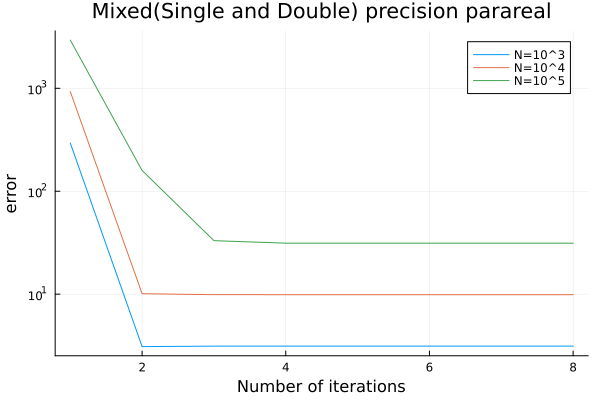

In [12]:
a=0
b=1
u0=1
nF=1000 # Fine grid
nG=15# Coarse grid
K=7 # Number of iteration

p = 3
N = zeros(p)
for i in 1:p
    N[i] = Int(floor(10^(i+2)))
end

err_msd=zeros(p, K+1)
# Parareal Solution
for i in 1:p
    Uk, Ufine, tval, δUk=mmsdparareal(Float64, a, b, u0, convert(Int, N[i]), mmsdFs, mmsdGs, K)

    # stroing errors
    
    for k in 1:K+1
        err_msd[i, k]=norm(Uk[k]-Ufine)
    end
end

using Plots
plot(err_msd[1,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=10^3",title="Mixed(Single and Double) precision parareal")
for j in 2:p
    plot!(err_msd[j,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=10^$(j+2)")
end
display(plot!(legend=:topright))

# Modified Parareal Algorithm in Mixed (Half and Double) Precision

In [13]:
# Modified Parareal method in mixed (Half and Double) precision
function mmhdparareal(::Type{T}, a, b, u0, N, F, G, K) where T<:AbstractFloat
    # a= start time value (t0)
    # b= End time value (tend)
    # N= Number of Subinterval
    # u0=initial Solution
    # F= Fine Solver
    # G= Coarse Solver
    # K= Parareal iteration
    
    tval=Vector(range(a, b, N+1))
    # Storing Fine Solution on each time step for comparison
    Ufine=Vector{Float64}(undef, N+1)
    Ufine[1]=u0
    for i in 1:N
        Ufine[i+1]=F(Float64, tval[i], tval[i+1], Ufine[i])
    end
    # Initializing Uk
    Uk=[Vector{Float64}(undef, N+1) for k in 1:K+1]
    #Storing the initial solution
    for k in 1:K+1
        Uk[k][1]=u0
    end
    # Parareal Initialization
    for j in 1:N
        #Uk[1][j+1]=G(tval[j], tval[j+1], Uk[1][j])
        Uk[1][j+1]=Float16(10) # may take random initial guess
    end
    # Parareal loop
    δUk=[Vector{Float16}(undef, N+1) for k in 1:K+1]
    for k in 1:K
        for i in 1:N
            δUk[k][i]=Uk[k+1][i]-Uk[k][i]
            Fk0=F(Float64,Float64(tval[i]), Float64(tval[i+1]), Uk[k][i])
            Gk=G(Float16, Float16(tval[i]), Float16(tval[i+1]), δUk[k][i])
            
            Uk[k+1][i+1]=Fk0 + Gk
        end
    end
    
    return Uk, Ufine, tval, δUk
  
end

mmhdparareal (generic function with 1 method)

In [14]:
function mmhdFs(Float64, a, b, u0)
    t, u=backeuler(Float64, a, b, Float64(u0), nF)
    return u[end]
end

mmhdFs (generic function with 1 method)

In [15]:
function mmhdGs(Float16, a, b, u0)
    t, u=backeuler(Float16, a, b, Float16(u0), nG)
    return u[end]
end

mmhdGs (generic function with 1 method)

# Convergence Analysis of Modified Parareal Algorithm in Mixed (Half and Double) Precision

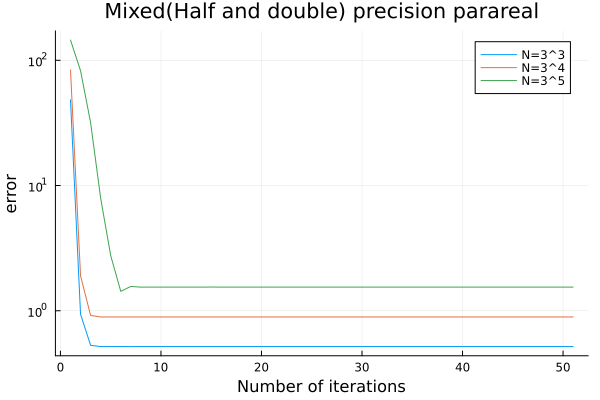

In [23]:
a=0
b=1
u0=1

nF=1000 # Fine grid
nG=15# Coarse grid
K=50 # Number of iteration


p = 3
N = zeros(p)
for i in 1:p
    N[i] = Int(floor(3^(i+2)))
end

err_mhd=zeros(p, K+1)
# Parareal Solution
for i in 1:p
    Uk, Ufine, tval, δUk = mmhdparareal(Float64, a, b, u0, convert(Int, N[i]), mmhdFs, mmhdGs, K)

    # stroing errors
    
    for k in 1:K+1
        err_mhd[i, k]=norm(Uk[k]-Ufine)
    end
end

using Plots
plot(err_mhd[1,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^3", title="Mixed(Half and double) precision parareal")
for j in 2:p
    plot!(err_mhd[j,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^$(j+2)")
end
display(plot!(legend=:topright))

In [22]:
err_mhd

3×101 Matrix{Float64}:
  48.3748   0.938283   0.53013   0.517894  …  0.517671  0.517671  0.517671
  83.7303   1.90261    0.917766  0.892867     0.892394  0.892394  0.892394
 144.992   82.5907    31.7605    7.93868      1.54625   1.54625   1.54617